In [1]:
import sys, os
import copy
import shutil
import pathlib
import time
import importlib
import joblib
import pickle
from tqdm import tqdm

import numpy as np

from scipy.linalg import null_space
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import cv2

In [2]:
import pickle
import itertools
import open3d as o3d
import numpy as np
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera, metashape_Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen, pair_pt_gen
from src import FR_check, coordinate_dict_gen
from src import min_dist, tri, TDlines_gen, reprojection_gen, gen_support_dict, gen_support
from src import all_D, frag_list_fraged, all_sep

In [4]:
def support_th(tags, temp_folder, sup_th):
    curve_fragment = []
    for tag in tags:
        if tag[1] == "R":
            continue

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            lines_list = pickle.load(f)

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            support_list, support_ac = pickle.load(f)
        #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
        tag_list = []
        for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
            col_curve_fragment = []
            for frag, sup, sup_ac in zip(col, sup_col, ac_col):
                if sup > sup_th:
                    frag = np.reshape(frag,(-1, 3))
                    frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                    col_curve_fragment.append(frag)
            tag_list.append(col_curve_fragment)
        curve_fragment.append(tag_list)
    return curve_fragment

def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry

angle = [0, np.pi/2, np.pi/2] # pcd.rotate()
angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])


def curve_fragment_align(curve_fragment):
    cfs = [[] for i in range(8)]
    for cols in curve_fragment:
        for i in range(len(cols)):
            cfs[i] += cols[i]
    temp_cfs = []
    for i, cf_label in enumerate(cfs):
        A = [frag  for frag in cf_label if frag.size!=0]
        temp_cfs.append(A)
    cfs = temp_cfs
    cfs = [list(map(lambda x: x*10@R@R_mirror, cf_label)) for cf_label in cfs]
    return cfs

def get_pts(mesh, edges, max_point_num=500):
    vertices = np.asarray(mesh.vertices)
    edges = np.asarray(edges)
    dist = 0
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist += dist_part
    unit_dist = dist/max_point_num
    next_start_length = 0
    next_start_partation = 0
    pts_list = []
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        next_st_pt = start + (end - start)*next_start_partation
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist_nx = np.sqrt(np.sum(np.square(next_st_pt - end)))
        pts_num = int(dist_nx/unit_dist)+1
        pts = next_st_pt + np.repeat(np.arange(pts_num),3).reshape((pts_num,3)) * (end - next_st_pt)/(pts_num-1)
        end_pts = pts[-1]
        next_start_length = pts_num*unit_dist - dist_part + next_start_length
        next_start_partation = next_start_length/dist_part
        pts_list.append(pts)

    pts_array = np.concatenate(pts_list)

    return pts_array

def mesh_contours_load(individual):
    mesh = o3d.io.read_triangle_mesh("postprocessing/polygon/quan_e_a/{}.ply".format(individual))
    edge_pts=[]
    for i in range(np.max(np.asarray(mesh.cluster_connected_triangles()[0]))+1):
        mesh = o3d.io.read_triangle_mesh("postprocessing/polygon/quan_e_a/{}.ply".format(individual))
        mesh.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles)[np.asarray(mesh.cluster_connected_triangles()[0])==i])
        #_, _, area = mesh.cluster_connected_triangles()
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
        pts_array = get_pts(mesh, edges)
        edge_pts.append(pts_array)
    return edge_pts

def edge_pts_shuffle_core(cfs, edge_pts):
    cfs_ave = np.array([np.average(np.concatenate(cf_label), axis=0) for cf_label in cfs])
    edge_pts_ave = np.array([np.average(edge_pt, axis=0) for edge_pt in edge_pts])
    cfs_ave_bro = np.repeat(cfs_ave, len(edge_pts_ave), axis=0).reshape(len(cfs_ave), len(edge_pts_ave), 3)
    cfs2edge_pts_idx = np.argmin(np.sum(np.square(cfs_ave_bro - edge_pts_ave),axis=2), axis=0)
    temp_edge_pts = copy.deepcopy(edge_pts)
    for i, idx in enumerate(cfs2edge_pts_idx):
        temp_edge_pts[i] = edge_pts[idx]
    edge_pts = temp_edge_pts
    return edge_pts

def cf_evaluation_core(edge_pts_label, cfs_label, t_dist=0.05, t_part=0.8):
    rec_TF_list = []
    for i, cf in enumerate(cfs_label):
        edge_pt_bro = np.repeat(edge_pts_label, len(cf), axis=0).reshape(edge_pts_label.shape[0], len(cf), edge_pts_label.shape[1])
        all_dist = np.sqrt(np.sum(np.square(cf - edge_pt_bro), axis=2))
        min_dist_idx_rec = np.argmin(all_dist.T, axis=1)
        min_dist_idx_pre = np.argmin(all_dist, axis=1)
        if i == 0:
            temp_dist_pre = np.ones(min_dist_idx_pre.shape)*1000
        min_dist_rec = all_dist.T[np.arange(len(all_dist.T)), min_dist_idx_rec]
        min_dist_pre = all_dist[np.arange(len(all_dist)), min_dist_idx_pre]
        rec_TF = (np.sum(min_dist_rec<t_dist)/len(min_dist_rec))>t_part
        rec_TF_list.append(rec_TF)
        temp_dist_pre[np.where(temp_dist_pre>min_dist_pre)[0]] = min_dist_pre[np.where(temp_dist_pre>min_dist_pre)[0]]
    recall = sum(rec_TF_list)/len(rec_TF_list)
    precision = np.sum(temp_dist_pre<t_dist)/len(temp_dist_pre)
    return precision, recall

def cf_evaluation(edge_pts, cfs):
    leaves_precision = []
    leaves_recall = []
    for edge_pts_label, cfs_label in zip(edge_pts, cfs):
        precision, recall = np.nan, np.nan
        if len(cfs_label) != 0:
            precision, recall = cf_evaluation_core(edge_pts_label, cfs_label)
        leaves_precision.append(precision)
        leaves_recall.append(recall)
    return leaves_precision, leaves_recall

def edge_pts_shuffle(tags, individual, img_num, temp_folder):
    curve_fragment = support_th(tags, temp_folder, 4)
    cfs = curve_fragment_align(curve_fragment)
    edge_pts = mesh_contours_load(individual)
    edge_pts = edge_pts_shuffle_core(cfs, edge_pts)
    return edge_pts


def evaluation(tags, individual, img_num, temp_folder):
    precision_list = []
    recall_list = []
    edge_pts = edge_pts_shuffle(tags, individual, img_num, temp_folder)
    for sup_th in list(range(img_num,-1,-4))[:int((len(list(range(img_num,-1,-4)))-1)*7/8)]:
        curve_fragment = support_th(tags, temp_folder, sup_th)
        cfs = curve_fragment_align(curve_fragment)
        precision, recall = cf_evaluation(edge_pts, cfs)
        precision_list.append(precision)
        recall_list.append(recall)
    return precision_list, recall_list

def get_tags(temp_folder):
    tags_path = list(temp_folder.glob("*.TDlines"))

    tags = []
    for tag_path in tags_path:
        tag_sp = tag_path.stem.split("_")
        tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
        tags.append(tag_arr)
    return tags


In [10]:
def all_prop(occs, noise, ind, img_num, temps_folder="temps"):
    if os.path.isfile(os.path.join('PR', occ, noise, ind, "{}_pre.pickle".format(img_num))):
        return
    zip_file = os.path.join(temps_folder, occ, noise, ind, str(img_num)+".zip")
    targz_file = os.path.join(temps_folder, occ, noise, ind, str(img_num)+".tar.gz")
    if os.path.isfile(zip_file):
        zip_file = zip_file
    else:
        zip_file = targz_file
    
    prefix_temp_folder = os.path.join(temps_folder, occ, noise, ind)
    temp_folder = pathlib.Path(os.path.join(prefix_temp_folder, "temp"))
    if temp_folder.exists():
        shutil.rmtree(str(temp_folder))
    shutil.unpack_archive(zip_file, prefix_temp_folder)
    print(os.path.join('PR', occ, noise, ind, str(img_num)))
    tags = get_tags(temp_folder)
    precision_list, recall_list = evaluation(tags, ind, img_num, temp_folder)
    
    os.makedirs(os.path.join('PR', occ, noise, ind), exist_ok=True)
    with open(os.path.join('PR', occ, noise, ind, "{}_pre.pickle".format(img_num)), 'wb') as f:
        pickle.dump(precision_list, f)
    with open(os.path.join('PR', occ, noise, ind,"{}_rec.pickle".format(img_num)), 'wb') as f:
        pickle.dump(recall_list, f)

In [9]:
20/128

0.15625

In [12]:

list(range(128,-1,-4))[:int((len(list(range(128,-1,-4)))-1)*7/8)]

[128,
 124,
 120,
 116,
 112,
 108,
 104,
 100,
 96,
 92,
 88,
 84,
 80,
 76,
 72,
 68,
 64,
 60,
 56,
 52,
 48,
 44,
 40,
 36,
 32,
 28,
 24,
 20]

In [11]:
temps_folder = pathlib.Path("temps")
occs = ["q_a", "q_aothin", "q_aothick"]
noises = ["0mm", "1mm", "3mm"]
inds = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]

In [12]:
for occ in occs:
    for noise in noises:
        for ind in inds:
            for img_num in img_nums:
                all_prop(occs, noise, ind, img_num, temps_folder="temps")

PR\q_a\0mm\q_1_a\128
PR\q_a\0mm\q_1_a\64
PR\q_a\0mm\q_1_a\32
PR\q_a\0mm\q_2_a\128
PR\q_a\0mm\q_2_a\64
PR\q_a\0mm\q_2_a\32
PR\q_a\0mm\q_3_a\128
PR\q_a\0mm\q_3_a\64
PR\q_a\0mm\q_3_a\32
PR\q_a\1mm\q_1_a\128
PR\q_a\1mm\q_1_a\64
PR\q_a\1mm\q_1_a\32
PR\q_a\1mm\q_2_a\128
PR\q_a\1mm\q_2_a\64
PR\q_a\1mm\q_2_a\32
PR\q_a\1mm\q_3_a\128
PR\q_a\1mm\q_3_a\64
PR\q_a\1mm\q_3_a\32
PR\q_a\3mm\q_1_a\128
PR\q_a\3mm\q_1_a\64
PR\q_a\3mm\q_1_a\32
PR\q_a\3mm\q_2_a\128
PR\q_a\3mm\q_2_a\64
PR\q_a\3mm\q_2_a\32
PR\q_a\3mm\q_3_a\128
PR\q_a\3mm\q_3_a\64
PR\q_a\3mm\q_3_a\32
PR\q_aothin\0mm\q_1_a\128
PR\q_aothin\0mm\q_1_a\64
PR\q_aothin\0mm\q_1_a\32
PR\q_aothin\0mm\q_2_a\128
PR\q_aothin\0mm\q_2_a\64
PR\q_aothin\0mm\q_2_a\32
PR\q_aothin\0mm\q_3_a\128
PR\q_aothin\0mm\q_3_a\64
PR\q_aothin\0mm\q_3_a\32
PR\q_aothin\1mm\q_1_a\128
PR\q_aothin\1mm\q_1_a\64
PR\q_aothin\1mm\q_1_a\32
PR\q_aothin\1mm\q_2_a\128
PR\q_aothin\1mm\q_2_a\64
PR\q_aothin\1mm\q_2_a\32
PR\q_aothin\1mm\q_3_a\128
PR\q_aothin\1mm\q_3_a\64
PR\q_aothin\1mm\q_3_

In [ ]:
def load_pickle(path):
    with open(str(path), 'rb') as f:
        loaded = pickle.load(f)
    return loaded

def load_occ(path):
    

In [72]:
targz_file =pathlib.Path("temps/q_aothin/0mm/q_1_a/128.tar.gz")
prefix_temp_folder = pathlib.Path("temps/q_aothin/0mm/q_1_a")

shutil.unpack_archive(targz_file, prefix_temp_folder)

In [ ]:
temp =pathlib.Path("temps/q_aothin/0mm/q_1_a/temp")

tags = get_tags(temp)

curves = support_th(tags, temp, 0)

In [73]:
cfs = curve_fragment_align(curves)

In [74]:
for i in range(len(cfs)):
    print(len(cfs[i]))

73304
53517
77297
75454
58731
77475
65272
74226


In [70]:
with open('preprocessing/labels/q_a_l/3mm/q_1_a/q_1_a_128_label.pickle', 'rb') as f:
    singer = pickle.load(f)

In [71]:
singer

[array([ 0., nan,  2.,  3.,  1.,  6.,  7.,  5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([ 0., nan,  2.,  3., nan,  6.,  7.,  5.]),
 array([ 0., nan,  2.,  3., nan,  6.,  7.,  3.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([ 0.,  1.,  2.,  3., nan,  6.,  7.,  5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 0., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 array([0., 1., 2., 3., 4., 6., 7., 5.]),
 a

In [ ]:
start = time.time()

temps_folder = pathlib.Path("q_e_temp")
temp = temps_folder / pathlib.Path("temp")
#zip_files = list(temps_folder.glob("*.zip"))
if temp.exists():
    shutil.rmtree(temp)
P_dict, R_dict = {}, {}
for zip_file in zip_files:
    img_num, individual = int(zip_file.stem.split("_")[-1]), "_".join(zip_file.stem.split("_")[0:3])
    shutil.unpack_archive(str(zip_file), str(temps_folder))
    tags = get_tags(temp)
    cam_list = get_camera(img_num, individual)
    precision_list, recall_list = evaluation(tags, individual, img_num, temp)
    
    with open('PR/q_e/{}_{}_pre.pickle'.format(individual, img_num), 'wb') as f:
        pickle.dump(precision_list, f)
    with open('PR/q_e/{}_{}_rec.pickle'.format(individual, img_num), 'wb') as f:
        pickle.dump(recall_list, f)
    
    P_dict[(img_num, individual)] = precision_list
    R_dict[(img_num, individual)] = recall_list
    shutil.rmtree(temp)
    
e_time = time.time() - start
print ("e_time:{0}".format(e_time) + "[s]")

In [ ]:
list(range(img_num,-1,-2))[:int(len(list(range(img_num,-1,-2)))*(3/4))+1]

In [ ]:
len(list(range(img_num,-1,-2)))

In [ ]:
int(len(list(range(img_num,-1,-2)))*(3/4))+1

In [59]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if j % 1 != 0:
                j+=1
                continue
            j+=1
            if frag.size < 10:
                continue
            if i != 0:
                continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            ax.plot(new[0], new[1], new[2],"-",color=c)


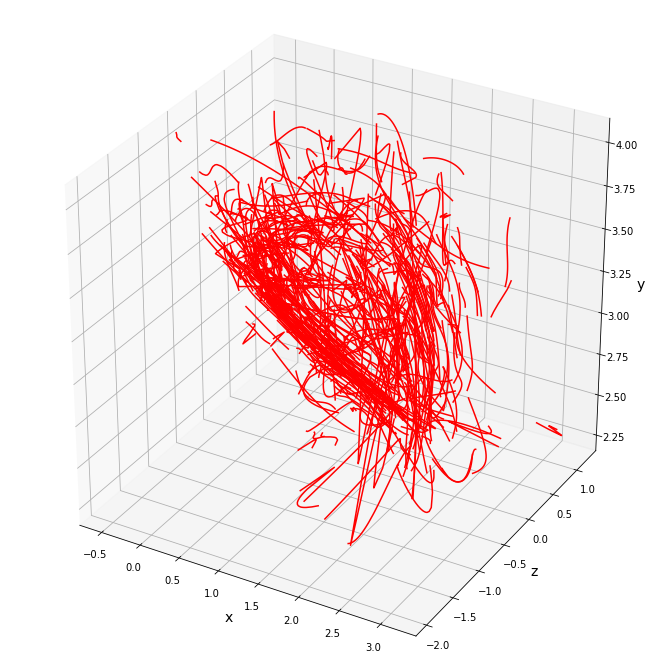

In [60]:
%matplotlib inline
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

plot_graph()